# `전체 과정`

### `파일1`
1. 실제 : 이미지를 yolo에 맞게 416x416으로 사이즈를 정규화한 이미지 dataset을 구축한다. ->  이때 비율은 유지하면서 리사이즈할 것
1. 임시(또는 실제) : 일단 데이터셋 구축된 것을 사용하고 학습단계에서 --imgsz 416을 이용해서 사이즈 정규화한다.

2. yolo를 학습시킨다
3. yolo 학습 파라미터를 저장한다


### `파일 2`

1. 저장된 yolo파라미터를 적용한 yolo모델을 만든다.

2. 이미지이름에 라벨링 정보가 포함된 이미지 폴더를 제공한다. ex) 아우터_무스탕_image1.jpg

3. 학습 파라미터가 적용된 yolo에 이미지 폴더 이미지를 넣는다.

4. 이미지를 투입시켜 yolo에서 탐지된 바운딩박스와 이미지이름에 포함된 라벨링 정보를 모은다.

5. 이때 바운딩 박스는 effcientnet 인풋에 맞는 사이즈(224x224)로 조정한다.

6. 이때 라벨은 총 40개의 클래스를 가진다.

7. 모아진 바운딩 박스와 라벨 정보를 이용해서 데이터셋을 구축하고 efficientent을 학습시킨다.

8. 원본 이미지는 학습 결과로 원본이미지와 분류된 클래스를 보여줄 것이기 때문에 dataset에 일단 포함한다.

9. efficientnet 학습 파라미터를 저장한다.


### `파일 3`

1. 학습된 yolo모델 파라미터를 적용한 yolo모델을 불러온다.

2. 학습된 efficientnet 파라미터를 적용한 efficientnet 모델을 불러온다.

3. 이미지를 제공한다

4. yolo 모델 + efficientnet 모델 통합 로직

- 1. 하나의 이미지가 yolo에 들어간다 -> bounding_box(들)을 추출한다. [`원본 이미지`✅, `bounding box(들)`✅]
- 2. bounding_box(들)에서 주요 옷 색상을 추출한다. [`색상 정보 추출`✅]
- 2. bounding_box(들)에서 대분류 정보를 추출한다. [`대분류 정보`✅]
- 3. yolo를 통해서 추출된 bounding box를 efficientnet input에 맞게 resize 한다. [`resize 이미지`✅]
- 4. resize된 bounding_box를 efficientnet에 넣고 소분류 정보를 추출한다. [`소분류 정보`✅]

# 이미지 사이즈 옵션 정리
- 1. (yolo - optional) 416 -> (efficientnet) 224
- 2. (yolo - optional) 620 -> (efficientnet) 400 (preferred)

# 구글 드라이브 연동하기

In [17]:
# 구글 드라이브 연동하기
from google.colab import drive
drive.mount('/content/drive')

# 경로 및 파일 관리
import os

# change directory 경로 변경하기
print(os.chdir('/content/drive/MyDrive'))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
None


# `파일 1`
1. 실제 : 이미지를 yolo에 맞게 416x416으로 사이즈를 정규화한 이미지 dataset을 구축한다. ->  이때 비율은 유지하면서 리사이즈할 것
1. 임시(또는 실제) : 일단 데이터셋 구축된 것을 사용하고 학습단계에서 --imgsz 416을 이용해서 사이즈 정규화한다.

2. yolo를 학습시킨다
3. yolo 학습 파라미터를 저장한다

### yolov5 파일 구글 드라이브에 설치하기 -> 새로운 것을 학습시킬 때만 실행할 것

In [ ]:
# # yolov5 파일 설치 경로 설정하기
# os.chdir('/content/drive/MyDrive/yolo_efficientnet')

# # 설정 경로에 yolov5 설치하기
# !git clone https://github.com/ultralytics/yolov5

### import

In [ ]:
# yolo5 파일에서 필요한 것을 설치하기 위한 경로 설정하기
os.chdir('/content/drive/MyDrive/yolo_efficientnet/yolov5')

# 환경 설정 파일 설치 -> [변경 내용] requests==2.31.0   pillow<10.1.0
%pip install -qr requirements.txt

# 공유 데이터셋 파일을 가져오기 위한 roboflow
%pip install -q roboflow

# 딥러닝 라이브러리
import torch

# yaml : json 또는 xml 처럼 데이터 송수신을 위해 사전에 정해진 규칙을 따르는 '데이터 전송 파일' 형식
import yaml

# 이미지 보여주는 용도
from PIL import Image as Img
from IPython.display import Image, display # clear_output

# 특정 확장자 파일 불러오기 -> glob.glob() : 특정 패턴과 일치하는 모든 경로명을 리스트로 반환
import glob

# 학습한 베스트 모델 다운로드하기
from google.colab import files

### 사전 작업

In [ ]:
# 데이터셋 파일 이름 정의 -> 해당 데이터셋의 이미지 =>  [연습] : 이미지 사이즈는 그대로 두고 학습코드에서 --imgsz로 resize 하기, [실전] : 416으로 리사이즈한 것으로 이미지 구축

dataset_file_name = 'main_fashion_dataset_for_yolov5' # ----------------------------------------------------------- 실전에서 변경할 부분! ------------------------------------------------------------------------

# 사용할 데이터셋 경로 지정 하기
dataset_directory = f'/content/drive/MyDrive/yolo_efficientnet/yolo_dataset/{dataset_file_name}'

# 데이터셋의 yaml 파일 경로 지정하기
dataset_yaml_directory = f'/content/drive/MyDrive/yolo_efficientnet/yolo_dataset/{dataset_file_name}/data.yaml'

In [ ]:
# 데이터셋/yaml 파일의 """원본"""을 load를 통해서 json으로 불러오기
with open(dataset_yaml_directory) as file :
    dataset_yaml = yaml.load(file, Loader = yaml.FullLoader)
    display(dataset_yaml)

In [ ]:
# yaml 파일의 train, val, test 데이터가 있는 경로 수정 (기존 경로 -> 구글 드라이브에 저장된 경로로)
dataset_yaml['train'] = '/content/drive/MyDrive/yolo_efficientnet/yolo_dataset/main_fashion_dataset_for_yolov5/train/images' # train.py로 학습하기
dataset_yaml['val'] = '/content/drive/MyDrive/yolo_efficientnet/yolo_dataset/main_fashion_dataset_for_yolov5/valid/images' # val.py로 검증하기
dataset_yaml['test'] = '/content/drive/MyDrive/yolo_efficientnet/yolo_dataset/main_fashion_dataset_for_yolov5/test/images' # detect.py로 테스트하기

# 경로 반영
with open(dataset_yaml_directory, 'w') as file:
    yaml.dump(dataset_yaml, file)

# 경로 반영 확인하기
print('변경된 yaml 파일 :')
with open(dataset_yaml_directory) as file:
    dataset_yaml = yaml.load(file, Loader=yaml.FullLoader)
    display(dataset_yaml)

### 학습하기

In [ ]:
# 학습 코드

!python train.py --imgsz 416 --batch 64 --epochs 100 --data {dataset_yaml_directory} --weights yolov5s.pt --cache

# train.py : 학습시키는 파일
# img : 입력 이미지 크기 -> 416
# batch : 한번에 학습시킬 이미지 수 -> 64개
# epoch : 학습 횟수 : 100
# data : dataset의 yaml 경로 -> dataset_yaml_directory
# weights : 적용할 가중치 선택(pretrained) -> pretrained된 yolo5s.pt 가중치 적용
# cache : 이미지를 캐시

# 학습 베스트 모델 저장 경로 : Results saved to runs/train/exp

In [ ]:
# 저장된 학습 best.pt경로 설정하기
train_exp_num = ''

trained_best_pt_path = f'/content/drive/MyDrive/yolo_efficientnet/yolov5/runs/train/exp{train_exp_num}/weights/best.pt'

### 검증하기

In [ ]:
# 검증하기
!python val.py --weights {trained_best_pt_path}  --data {dataset_yaml_directory} --imgsz 416

# val.py : 검증하는 파일
# weights : 검증 시 적용할 가중치
# data : 검증 이미지 경로가 있는 yaml 파일
# imgsz : 이미지 사이즈 -> 416

In [ ]:
# 검증 결과 저장 경로 : Results saved to runs/val/exp
valid_exp_num = ''

### 테스트하기

In [ ]:
# 테스트하기
!python detect.py --weights {trained_best_pt_path} --imgsz 416 --conf-thres 0.3 --source {dataset_yaml['test']}

# detect.py : 테스트하는 파일
# weights : 테스트 시 적용할 가중치
# imgsz : 이미지 사이즈 -> 416
# conf-thres : 신뢰도 임계값(해당 수치 이상만 결과에 반영) -> 0.3
# source : 이미지 """폴더"""가 있는 경로 설정

In [ ]:
# 테스트 결과 저장 경로 : Results saved to runs/detect/exp
detect_exp_num = ''

### 사전 구축 테스트 결과 확인하기

In [ ]:
# 테스트 결과가 없으면
if not os.path.exists(f'/content/drive/MyDrive//yolo_efficientnet/yolov5/runs/detect/exp{detect_exp_num}'):
  # 에러를 발생시켜서 debugging 하기
  raise Exception('에러 발생 !!!!! test_exp_num를 확인하거나, 학습을 진행하지 않았을 경우 학습을 진행해주세요!.')


# .jpg 확장자 파일을 반복문 돌면서
for image_path in glob.glob(f'/content/drive/MyDrive/yolo_efficientnet/yolov5/runs/detect/exp{detect_exp_num}/*.jpg') :
    # 테스트 결과 확인하기
    display(Image(filename=image_path))
    print("\n")

### imgsz 적용 결과 확인하기
- 모델 인풋 차원에서만 임시 변형이기 때문에 기존 이미지 사이즈가 나온다.

In [ ]:
# 이미지 사이즈 확인하기
image_size_list = []
for image_path in glob.glob(f'/content/drive/MyDrive/yolo_efficientnet/yolov5/runs/detect/exp{detect_exp_num}/*.jpg') :
    image_exp = Img.open(image_path)
    image_size_list.append(image_exp.size)

print('img size :', set(image_size_list))

### 최종 학습 파라미터 다운로드 후 경로 설정하기

In [ ]:
# 다운로드할 pt 파일 경로 설정하기
train_best_pt_download_path = f'/content/drive/MyDrive/yolo_efficientnet/yolov5/runs/train/exp{train_exp_num}/weights/best.pt'

# pt 파일 다운로드하기
files.download(train_best_pt_download_path)

In [ ]:
# 저장 경로 설정(기록)하기
yolov5_best_pt_save_path = '/content/drive/MyDrive/yolo_efficientnet/yolo_best.pt/fashion_yolov5_best.pt'

# `파일 2`

1. 저장된 yolo파라미터를 적용한 yolo모델을 만든다.

2. 이미지이름에 라벨링 정보가 포함된 이미지 폴더를 제공한다. ex) 아우터_무스탕_image1.jpg

3. 학습 파라미터가 적용된 yolo에 이미지 폴더 이미지를 넣는다.

4. 이미지를 투입시켜 yolo에서 탐지된 바운딩박스와 이미지이름에 포함된 라벨링 정보를 모은다.

5. 이때 바운딩 박스는 effcientnet 인풋에 맞는 사이즈(224x224)로 조정한다.

6. 이때 라벨은 총 40개의 클래스를 가진다.

7. 모아진 바운딩 박스와 라벨 정보를 이용해서 데이터셋을 구축하고 efficientent을 학습시킨다.

8. 원본 이미지는 학습 결과로 원본이미지와 분류된 클래스를 보여줄 것이기 때문에 dataset에 일단 포함한다.

9. efficientnet 학습 파라미터를 저장한다.

### import

In [18]:
# 딥러닝 사용
import torch

# 특정 확장자 파일 불러오기 -> glob.glob() : 특정 패턴과 일치하는 모든 경로명을 리스트로 반환
import glob

# 이미지 관련
from PIL import Image as Img
from PIL import ImageFile
import cv2
import numpy as np
import glob
from IPython.display import display

# 파일 관리
import os

# efficientNet_v2_s 모델을 가지고오기 위함
import torchvision.models as get_model
import torchvision

# input 데이터를 정규화하기 위한 transform 규칙을 적용하기 위함
import torchvision.transforms as transforms

# optimizer를 가지고 오기 위함.
import torch.optim as optim

# pytorch에서 지원하는 다양한 계층 및 손실함수 계산을 사용하기 위함.
import torch.nn as nn

from torchvision.datasets import ImageFolder
from torchvision import transforms # ToTensor, Resize, Compose
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, DataLoader

# 스케쥴러
from torch.optim.lr_scheduler import OneCycleLR

### 저장된 학습 yolo 모델 불러오기

In [ ]:
# 학습결과를 적용한 모델 불러오기 -> yolov5_best_pt_save_path 적용
model = torch.hub.load('ultralytics/yolov5', 'custom', path = yolov5_best_pt_save_path )

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-6-20 Python-3.10.12 torch-2.3.0+cu121 CPU

Fusing layers... 
Model summary: 157 layers, 7031701 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


### yolo input으로 넣기 위한 custom 이미지 폴더 경로 지정하기
- 해당 이미지 폴더는 다음과 같이 사이즈가 정규화 되어져 있어야 한다.
    - 1. (yolo) 416 (비율 유지)
    - 2. (yolo) 620 (비율 유지)

In [ ]:
# custom_test 및 dataset 구축 전용 폴더 경로
custom_image_path = "/content/drive/MyDrive/yolo_efficientnet/custom_test_images/*.jpg"


### 이미지 비율을 유지하면서 resize하는 함수 정의

In [4]:
def maintain_proportion_and_resize_by_cv2(image_path, size=(416, 416)):

    # 이미지 읽기(BGR)
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"이미지를 열 수 없습니다: {image_path}")

    # 이미지 형식 변경하기(BGR -> RGB)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # 높이, 너비 추출
    original_height, original_width = image.shape[:2]

    # 비율 계산
    ratio = min(size[0] / original_width, size[1] / original_height)
    new_width = int(original_width * ratio)
    new_height = int(original_height * ratio)

    # 이미지 리사이즈
    resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)

    # 새로운 이미지를 패딩하여 416x416 크기로 만들기
    new_image = np.full((size[1], size[0], 3), (255, 255, 255), dtype=np.uint8)  # 흰색 배경으로 초기화
    x_offset = (size[0] - new_width) // 2
    y_offset = (size[1] - new_height) // 2
    new_image[y_offset:y_offset + new_height, x_offset:x_offset + new_width] = resized_image

    return new_image


def maintain_proportion_and_resize_by_pil(image, size=(416, 416)):

    # PIL.Image 형식의 이미지를 비율을 유지하면서 지정된 크기로 리사이즈하고,
    # 흰색 배경으로 패딩하여 최종 이미지를 반환

    # 원본 이미지 크기 추출
    original_width, original_height = image.size

    # 비율 계산
    ratio = min(size[0] / original_width, size[1] / original_height)
    new_width = int(original_width * ratio)
    new_height = int(original_height * ratio)

    # 이미지 리사이즈
    resized_image = image.resize((new_width, new_height), Img.ANTIALIAS)

    # 새로운 이미지를 패딩하여 지정된 크기로 만들기
    new_image = Img.new("RGB", size, (255, 255, 255))  # 흰색 배경으로 초기화
    x_offset = (size[0] - new_width) // 2
    y_offset = (size[1] - new_height) // 2
    new_image.paste(resized_image, (x_offset, y_offset))

    return new_image

### yolo(original_image) = yolo_output = bounding_box
- bounding_box = 데이터셋 구축을 위한 이미지
- 이미지 이름 = label(정답)
- original_image = 추후 결과를 보여주기 위해 계속 가지고 가야함.

클래스 라벨 사전 정의

In [ ]:
classes_composition_list = ['니트','후드','맨투맨','셔츠/블라우스','긴소매 티셔츠','반소매 티셔츠','민소매 티셔츠','카라 티셔츠','베스트','데님 팬츠','슬랙스','트레이닝/조거팬츠','숏팬츠','코튼 팬츠','레깅스','와이드 팬츠','후드 집업','바람막이',
'코트','롱패딩','숏패딩','패딩 베스트','블루종/MA-1','레더 자켓','무스탕','트러커 자켓','블레이저','가디건','뽀글이 후리스','사파리 자켓','미니 원피스','미디 원피스','투피스','롱원피스','점프수트','미니 스커트','미디 스커트','롱 스커트']

cls_labels = {cls : i+1 for i, cls in enumerate(classes_composition_list)}

In [ ]:
# 데이터셋 구축을 위해 yolo에서 탐지된 result를 모을 리스트 정의 -> result에는 바운딩 박스 포함
dataset_image_composition_list = []

# 데이터셋 구축을 위해 original_image 파일명에 포함된 label을 모을 리스트 정의
label_composition_list = []

# 탐지 성공 개수 정의
detect_success = 0

# 탐지 실패 개수 정의
detect_fail = 0

print(f'{len(glob.glob(custom_image_path))}개의 이미지를 분석하겠습니다.')

# custom_image_path에 있는 이미지를 하나씩 보면서
for image_path in glob.glob(custom_image_path):

    print(f'해당 이미지 파일 분석 중 : {image_path}')

    # original_image 정의 -> 객체 탐지에 실패했을 때는 bounding_box 대신 original_image를 input으로 만든다.
    natural_img = cv2.imread(image_path)
    natural_img = cv2.cvtColor(natural_img, cv2.COLOR_BGR2RGB)

    # resize_image(yolo모델 인풋) 정의
    resized_img = maintain_proportion_and_resize_by_cv2(image_path, (640, 640))
    resized_img_for_cropping = maintain_proportion_and_resize_by_cv2(image_path, (640, 640))

    # label(소분류) 정의 -> 가정 : image_path = custom_image_path/대분류_소분류_image_숫자.jpg
    image_label = image_path.split('/')[-1].split('_')[1]

    # resized_image를 model의 인풋으로 넣고 output 정의
    result = model(resized_img)

    # 탐지 결과가 있으면
    if len(result.xyxy[0]) != 0:

        print(f'{image_path}의 탐지 결과를 출력합니다')

        # 탐지 결과 보여주기
        result.show()

        # 탐지 성공 횟수 모으기
        detect_success += 1

        print(f'{image_path}의 bounding_box 추출 결과를 출력합니다')

        # bounding_box 추출 결과 확인
        for i, bounding_box in enumerate(result.xyxy[0]):
            xmin, ymin, xmax, ymax = map(int, bounding_box[:4])
            cls = int(bounding_box[5])
            confidence = round(bounding_box[4].item(), 2)

            # 이미지 자르기
            cropped_img = resized_img_for_cropping[ymin:ymax, xmin:xmax]

            # 클래스 이름
            class_name = result.names[cls]

            # crop된 이미지를 데이터셋으로 모으기
            dataset_image_composition_list.append(Img.fromarray(cropped_img, 'RGB'))

            # 라벨 모으기
            label_composition_list.append(cls_labels[image_label])

            print(f"탐지된 객체 {i+1}: 클래스 = {class_name}, 신뢰도 = {confidence * 100}%")

            # 자른 이미지를 그대로 사용 (추가 변환 필요 없음)
            display(Img.fromarray(cropped_img, 'RGB'))

        print('------------------------------------------')

    # 탐지 결과가 없으면
    else:
        # 원본 이미지를 데이터셋으로 모으기
        dataset_image_composition_list.append(Img.fromarray(natural_img, 'RGB'))

        # 라벨 모으기
        label_composition_list.append(cls_labels[image_label])

        print(f'{image_path}의 탐지 결과가 없습니다.')
        print('------------------------------------------')

        # 탐지 실패 횟수 반영하기
        detect_fail += 1

print(f'탐지 성공 비율: {round(detect_success/len(glob.glob(custom_image_path)) * 100, 2)}')
print(f'탐지 실패 비율 : {round(detect_fail/len(glob.glob(custom_image_path)) * 100, 2)}')

# debugging 용
print(len(dataset_image_composition_list), len(label_composition_list))



Output hidden; open in https://colab.research.google.com to view.

In [ ]:
for a in dataset_image_composition_list :
    display(maintain_proportion_and_resize_by_pil(a, (400, 400)))

Output hidden; open in https://colab.research.google.com to view.

### 데이터셋 정의

- 필수 구현
    - __init__ : 생성자 정의
    - __len__ : 길이 정의
    - __getitem__ : 반환 형태 정의

In [ ]:
class EfficientNetDataset(Dataset):
    def __init__(self, dataset_image_composition_list, label_composition_list, transform=None):

        self.dataset_image_composition_list = dataset_image_composition_list

        self.label_composition_list = label_composition_list

        self.transform = transform

    def __len__(self):

        return len(self.dataset_image_composition_list)

    def __getitem__(self, idx):

        image = self.dataset_image_composition_list[idx]

        label = self.label_composition_list[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

### transform 정의
- transform 해야 하는 이유
    - 데이터 표준화: 모델에 입력되는 이미지의 크기, 형태 등을 일정하게 맞춰주는 작업
    - 데이터 증강: 학습 데이터셋의 다양성을 높여 모델의 일반화 성능 높이기
    - 텐서 변환: 이미지를 PyTorch에서 사용하는 텐서 형태로 변환

In [ ]:
transform = transforms.Compose([
    # 직접 정의한 resize, crop 함수 적용
    transforms.Lambda(lambda image : maintain_proportion_and_resize_by_pil(image, size = (400, 400))),
    # 랜덤하게 이미지를 좌우 반전 -> 일반화 성능 향상
    transforms.RandomHorizontalFlip(),
    # 이미지를 랜덤하게 10도 이내로 회전 -> 일반화 성능 향상
    transforms.RandomRotation(10),
    # 밝기, 대비, 채도, 색조 조정 -> 다양한 조명 아래에서 찍히는 옷 이미지 특성 상 필수적..
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    # 이미지를 텐서로 변환
    transforms.ToTensor(),
    # 이미지 정규화 -> 일반화 성능 향상
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### 데이터셋 생성 / 데이터로더 생성 및 정의

In [ ]:
from sklearn.model_selection import train_test_split

# dataset_image_composition_list, label_composition_list 을 train과 test로 분리하기
train_image_composition_list, valid_image_composition_list, train_label_composition_list, valid_label_composition_list = train_test_split(
    dataset_image_composition_list,
    label_composition_list,
    test_size = 0.2,
    random_state = 40)

# train dataset 정의하기
train_dataset = EfficientNetDataset(train_image_composition_list, train_label_composition_list, transform=transform)

# valid dataset 정의하기
valid_dataset = EfficientNetDataset(valid_image_composition_list, valid_label_composition_list, transform=transform)

# train_dataloader 정의하기
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# valid dataloader 정의하기
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

### EfficientNet 로드 및 학습

In [ ]:
# device 정의
device = torch.device('cuda'if torch.cuda.is_available else 'cpu')

# pytorch에 있는 사전 학습 EfficientNet 모델 불러오기
effnet_v2_s_model = get_model.efficientnet_v2_s(pretrained=True)

# effnet_v2_s_model의 연산 공간 device 정의
effnet_v2_s_model.to(device)

In [ ]:
# 모델 계층 이름 확인하기
for name, param in effnet_v2_s_model.named_parameters() :
    print(name)

In [ ]:
# 클래스 수에 맞게 out_features 조정하기
num_class = 38

print('[변경 전]')
print(effnet_v2_s_model.classifier)

effnet_v2_s_model.classifier[1] = torch.nn.Linear(effnet_v2_s_model.classifier[1].in_features, num_class)

print('[변경 전]')
print(effnet_v2_s_model.classifier)




[변경 전]
Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=38, bias=True)
)
[변경 전]
Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=38, bias=True)
)


In [ ]:
# 손실함수, 옵티마이저, 스케쥴러 정의
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(effnet_v2_s_model.parameters(), lr=0.001)
scheduler = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=10,
                       pct_start=0.3, anneal_strategy='cos', div_factor=25.0, final_div_factor=10000.0)

# max_lr : 최대 학습률 -> 초기 학습률은 크게하고 점차 감소시키기 위해서 높은 값을 사용한다.
# steps_per_epoch=len(train_loader): 한 에포크당 스텝 수를 설정
# epochs=10: 전체 에폭 수와 동일하게 설정한다. 몇 번의 학습동안 스케쥴링할 지 결정
# pct_start=0.3: 전체 학습 기간 중 학습률이 증가하는 비율을 설정(30% : 증가, 70% : 감소)
# anneal_strategy='cos': 학습률을 코사인 함수 형태로 감소
# div_factor=25.0: 초기 학습률을 max_lr에 나누는 값(초기 학습률 = max_lr / 25)
# final_div_factor=10000.0: 최종 학습률을 초기 학습률에 나누는 값(최종 학습률 = 초기 학습률 / 10000)

In [ ]:
from tqdm import tqdm

# effnet_v2_s_model.to(device) # 혹시라도 device가 안맞다는 에러 발생 시 실행할 것

# 학습 횟수
epochs = 100

for epoch in range(epochs):
    # 한 에폭에서 학습모드 검증모드를 왔다갔다 하기 때문에 반복문 안에서 학습모드 선언
    effnet_v2_s_model.train()

    train_loss = 0.0
    train_total = 0
    train_correct = 0

    for inputs, labels in tqdm(train_loader):
        # 계산할 디바이스 정의하기
        inputs, labels = inputs.to(device), labels.to(device)
        # optimizer가 이전 결과에 대한 미분값을 가지고 있으면 가중치를 이상하게 학습시킬 가능성이 있으므로
        optimizer.zero_grad()

        # 모델에 inputs을 넣어서 outputs을 산출받고
        outputs = effnet_v2_s_model(inputs)
        # 모델 결과와 실제 정답을 비교해서 loss를 계산하고
        loss = loss_func(outputs, labels)
        # 역전파를 진행하고
        loss.backward()
        # 가중치를 업데이트하고
        optimizer.step()
        # 각 배치에서 학습률을 조정한다.
        scheduler.step()

        # tensor에 있는 값을 item()을 통해 숫자로 꺼내와서 각 이미지와 라벨에 대한 손실을 모두 누적하고
        train_loss += loss.item()


        _, predicted = torch.max(outputs, 1)
        # 각 배치의 전체 개수
        train_total += labels.size(0)
        # 각 배치의 맞춘 것의 개수
        train_correct += (predicted == labels).sum().item()

    # 손실을 평균값으로 계산
    epoch_loss = train_loss / len(train_loader)
    # 전체 이미지에 대해서 분류를 성공한 것의 비율을 구한다.
    epoch_accuracy = (train_correct / train_total) * 100

    print(f'Train_Epoch [{epoch+1}/{epochs}], Train_Loss: {epoch_loss:.4f}, Train_Accuracy: {epoch_accuracy:.2f}%')

    # 검증 모드 설정하기
    effnet_v2_s_model.eval()

    valid_loss = 0.0
    valid_total = 0
    valid_correct = 0

    # 검증 단계에서는 기울기 계산을 하지 않으므로
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = effnet_v2_s_model(inputs)

            loss = loss_func(outputs, labels)
            # 검증 모드이기 때문에
            # 역전파 X
            # 파라미터 업데이트 X
            # 스케쥴러 업데이트 X

            valid_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            valid_total += labels.size(0)
            valid_correct += (predicted == labels).sum().item()

    # 검증 손실을 평균값으로 계산
    valid_loss = valid_loss / len(valid_loader)
    # 검증 데이터에서의 정확도 계산
    valid_accuracy = (valid_correct / valid_total) * 100

    print(f'Valid_Epoch [{epoch+1}/{epochs}], Valid_Loss: {valid_loss:.4f}, Valid_Accuracy: {valid_accuracy:.2f}%')


### 학습된 파라미터 저장하기

In [ ]:
# pt 파일 이름 정의
pt_save_name = ''

# pt 파일 저장할 경로 정의
efficientnet_pt_save_path = '/content/drive/MyDrive/yolo_efficientnet/efficientnet_train.pt/'

# 모델 학습 파라미터 저장하기
torch.save(effnet_v2_s_model.state_dict(), efficientnet_pt_save_path + f'{pt_save_name}.pt')

# 파일 3

1. 학습된 yolo모델 파라미터를 적용한 yolo모델을 불러온다.

2. 학습된 efficientnet 파라미터를 적용한 efficientnet 모델을 불러온다.

3. 이미지를 제공한다

4. yolo 모델 + efficientnet 모델 통합 로직

- 1. 하나의 이미지가 yolo에 들어간다 -> bounding_box(들)을 추출한다. [`원본 이미지`✅, `bounding box(들)`✅]
- 2. bounding_box(들)에서 주요 옷 색상을 추출한다. [`색상 정보 추출`✅]
- 2. bounding_box(들)에서 대분류 정보를 추출한다. [`대분류 정보`✅]
- 3. yolo를 통해서 추출된 bounding box를 efficientnet input에 맞게 resize 한다. [`resize 이미지`✅]
- 4. resize된 bounding_box를 efficientnet에 넣고 소분류 정보를 추출한다. [`소분류 정보`✅]


In [19]:
device = torch.device('cuda'if torch.cuda.is_available else 'cpu')

### 학습된 yolo 모델 불러오기

In [ ]:
# yolov5 pt 파일 저장 이름 정의
yolov5_best_pt_save_name = 'fashion_yolov5_best'

# yolo pt 파일 저장 경로 정의
yolov5_best_pt_save_path = f'/content/drive/MyDrive/yolo_efficientnet/yolo_best.pt/{yolov5_best_pt_save_name}.pt'
yolov5_best_pt_save_path = '/content/drive/MyDrive/yolo_efficientnet/yolo_best.pt/fashion_yolov5_best.pt'

# 학습 가중치를 적용한 모델 불러오기
yolov5_model = torch.hub.load('ultralytics/yolov5', 'custom', path= yolov5_best_pt_save_path )

# device 설정
yolov5_model.to(device)

# yolov5_model 평가 모드 선언
yolov5_model.eval()

### 학습된 EfficientNet 모델 불러오기

In [21]:
# 학습되지 않은 초기화 efficientnetv2_s 모델 불러오기
effnet_v2_s_model = get_model.efficientnet_v2_s(pretrained=False)


# 학습된 pt 파일의 out_features 개수
num_classes = 10

# out_features 클래스 개수 맞춰 주기
in_features = effnet_v2_s_model.classifier[1].in_features
effnet_v2_s_model.classifier[1] = nn.Linear(in_features, num_classes)

# 반영 여부 확인
print('pt 적용 전 계층 구조 맞추기')
print(effnet_v2_s_model.classifier)


# 학습된 efficientnet pt 파일 이름 정의
efficientnet_pt_save_name = 'cifar10_train'

# pt 파일 저장할 경로 정의
# efficientnet_pt_save_path = f'/content/drive/MyDrive/yolo_efficientnet/efficientnet_train.pt/{efficientnet_pt_save_name}.pt'
efficientnet_pt_save_path= f'/content/drive/MyDrive/yolo_efficientnet/etc_composition/{efficientnet_pt_save_name}.pt'


# checkpoint 정의 -> 기존에 학습된 파라미터 정보를 가지고 있다
check_point = torch.load(efficientnet_pt_save_path)

# 초기화된 모델의 파라미터 얻기
model_dict = effnet_v2_s_model.state_dict()

# checkpoint와 초기화 모델의 파라미터를 비교하면서 사전 학습된 내용을 반영하기
pretrained_dict = {k: v for k, v in check_point.items() if k in model_dict and 'classifier.1' not in k}

# model.dict에 사전 학습 파라미터 반영
model_dict.update(pretrained_dict)

# 초기화 모델에 사전 학습 파라미터 반영하기
effnet_v2_s_model.load_state_dict(model_dict)

# device 설정
effnet_v2_s_model.to(device)

# 평가 모드 선언
effnet_v2_s_model.eval()

# 계층 적용 여부 점검 -> out_features : 38개여야 됨.
print('pt 적용 후 계층 구조 확인')
print(effnet_v2_s_model.classifier)


pt 적용 전 계층 구조 맞추기
Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=10, bias=True)
)
pt 적용 후 계층 구조 확인
Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=10, bias=True)
)


### yolo 모델 + efficientnet 모델 통합 로직

- 1. 하나의 이미지가 yolo에 들어간다 -> bounding_box(들)을 추출한다. [`원본 이미지`✅, `bounding box(들)`✅]

- 2. bounding_box(들)에서 주요 옷 색상을 추출한다. [`색상 정보 추출`✅]

- 3. bounding_box(들)에서 대분류 정보를 추출한다. [`대분류 정보`✅]


In [32]:
!pip install extcolors

In [39]:
color_ranges = {
    "red": ((128, 0, 0), (255, 127, 127)),
    "green": ((0, 128, 0), (127, 255, 127)),
    "blue": ((0, 0, 128), (127, 127, 255)),
    "yellow": ((128, 128, 0), (255, 255, 127)),
    "magenta": ((128, 0, 128), (255, 127, 255)),
    "cyan": ((0, 128, 128), (127, 255, 255)),
    "orange": ((128, 64, 0), (255, 191, 127)),
    "purple": ((64, 0, 64), (191, 127, 191)),
    "pink": ((255, 0, 127), (255, 191, 255)),
    "lime": ((0, 255, 0), (191, 255, 191)),
    "brown": ((64, 32, 0), (191, 127, 64)),
    "gray": ((128, 128, 128), (191, 191, 191)),
    "black": ((0, 0, 0), (63, 63, 63)),
    "white": ((192, 192, 192), (255, 255, 255))
}


def get_color_name(rgb_value):
    for color_name, (lower_bound, upper_bound) in color_ranges.items():
        # 특정 색깔 범위에 있으면
        if all(lower_bound[i] <= rgb_value[i] <= upper_bound[i] for i in range(3)):
            return color_name
    return "UNKNOWN"

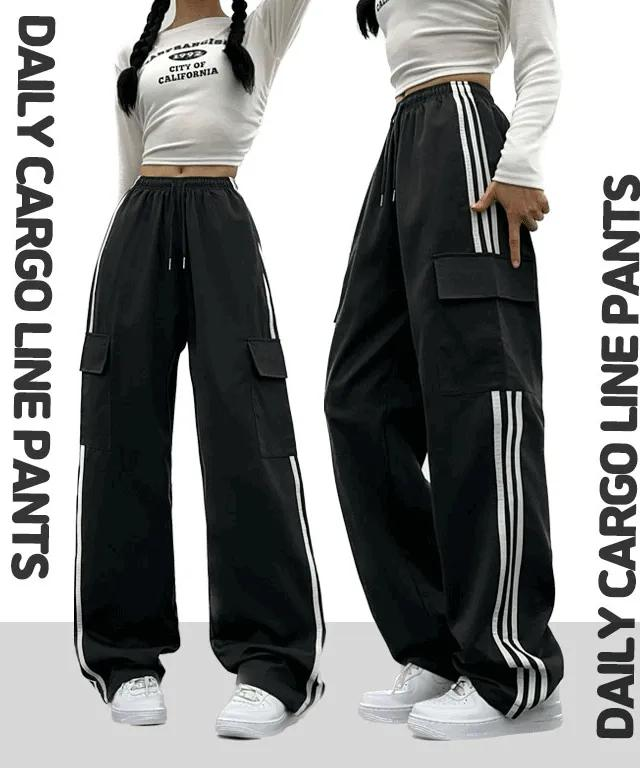

2개의 탐지 결과가 있습니다


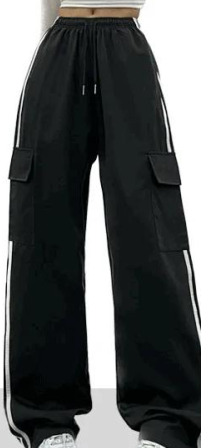

바지_트레이닝 조거팬츠_image_198.jpg에서 탐지한 1번쨰 옷의 대분류는 pants입니다.  가장 많이 등장한 색상은 black 입니다. -> 결과 신뢰도 : 61.0


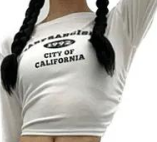

바지_트레이닝 조거팬츠_image_198.jpg에서 탐지한 2번쨰 옷의 대분류는 sweater입니다.  가장 많이 등장한 색상은 white 입니다. -> 결과 신뢰도 : 61.0


In [43]:
import glob
import cv2
from IPython.display import display
from PIL import Image as Img
import extcolors


# test dataset 이름 정의
test_dataset_name = ''

# test dataset 경로 정의
# image_dataset_to_test_path = f'/content/drive/MyDrive/yolo_efficientnet/all_yolo_effnet_totoal_dateset/{test_dataset_name}/*.jpg'
image_dataset_to_test_path = "/content/drive/MyDrive/yolo_efficientnet/custom_test_images/*.jpg"



# test 이미지 정의
test_image_path = glob.glob(image_dataset_to_test_path)[8]

# natural_image 만들기
natural_img = cv2.imread(test_image_path)
natural_img = cv2.cvtColor(natural_img, cv2.COLOR_BGR2RGB)
natural_img = Img.fromarray(natural_img)

# [원본 이미지✅]
display(natural_img)


resized_img = maintain_proportion_and_resize_by_cv2(test_image_path, (640, 640))
resized_img_for_cropping = maintain_proportion_and_resize_by_cv2(test_image_path, (640, 640))

result = yolov5_model(resized_img)

if len(result.xyxy[0]) != 0:
    print(f'{len(result.xyxy[0])}개의 탐지 결과가 있습니다')

else :
    print('탐지 결과가 없습니다.')

detected_image_composition_list = []

for i, bounding_box in enumerate(result.xyxy[0]):
    xmin, ymin, xmax, ymax = map(int, bounding_box[:4])
    cls = int(bounding_box[5])
    # [대분류 정보✅]
    class_name = result.names[cls]
    confidence = round(bounding_box[4].item(), 2)

    # bounding box 보여주기
    cropped_img = resized_img_for_cropping[ymin:ymax, xmin:xmax]
    cropped_img = Img.fromarray(cropped_img, 'RGB')
    detected_image_composition_list.append(cropped_img)
    # [bounding box(들)✅]
    display(cropped_img)


    colors, pixel_count = extcolors.extract_from_image(cropped_img)
    # [색상 정보 추출✅]
    print(f'{test_image_path.split("/")[-1]}에서 탐지한 {i+1}번쨰 옷의 대분류는 {class_name}입니다.  가장 많이 등장한 색상은 {get_color_name(colors[0][0])} 입니다. -> 결과 신뢰도 : {confidence * 100}')


- 4. yolo를 통해서 추출된 bounding box를 efficientnet input에 맞게 resize 한다. [`resize 이미지`]
- 5. resize된 bounding_box를 efficientnet에 넣고 소분류 정보를 추출한다. [`소분류 정보`]


<ipython-input-4-49375529a06c>:45: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = image.resize((new_width, new_height), Img.ANTIALIAS)


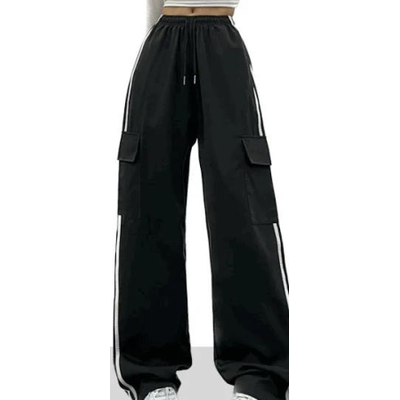

1


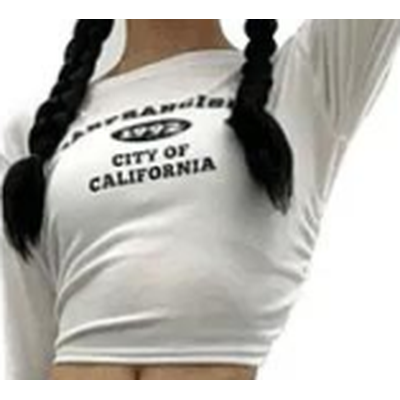

2


In [53]:
import torchvision.transforms as transforms

# 이미지 전처리 정의
image_to_tensor = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# bounding box 모은 것을 반복문 돌리면서 resize 하기 -> (400, 400)
# [resize 이미지✅]
for detected_image in detected_image_composition_list :
    resized_image = maintain_proportion_and_resize_by_pil(detected_image, (400, 400))

    display(resized_image)

    resized_image = image_to_tensor(resized_image)
    resized_imgae = resized_image.unsqueeze(0).to(device)



    with torch.no_grad():
        outputs = effnet_v2_s_model(resized_imgae)

    max_value, max_index  = torch.max(outputs, 1)
    # [소분류 정보✅]
    print(max_index.item())